In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from grid_world import GridWorld
from draw import draw


In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = set()
        # self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        # self.buffer.append((state, action, reward, next_state, done))
        self.buffer.add((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(list(self.buffer), batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)


In [3]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [4]:
class DQN:
    def __init__(
        self,
        state_dim,
        hidden_dim,
        action_dim,
        learning_rate,
        gamma,
        epsilon,
        target_update,
        device,
    ):
        super(DQN, self).__init__()
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict["states"], dtype=torch.float).to(
            self.device
        )
        actions = torch.tensor(transition_dict["actions"]).view(-1, 1).to(self.device)
        rewards = (
            torch.tensor(transition_dict["rewards"], dtype=torch.float)
            .view(-1, 1)
            .to(self.device)
        )
        next_states = torch.tensor(
            transition_dict["next_states"], dtype=torch.float
        ).to(self.device)
        dones = (
            torch.tensor(transition_dict["dones"], dtype=torch.float)
            .view(-1, 1)
            .to(self.device)
        )

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


In [5]:
# env_name = "CartPole-v0"
# env = gym.make(env_name)
rows = 5  # 记得行数和列数这里要同步改
columns = 5
env = GridWorld(
    forbidden_score=-10, terminal_score=10, desc=[".....", ".##..", "..#..", ".#T#.", ".#..."]
)
env.render_grid()

⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


Iteration 0: 100%|██████████| 50/50 [00:02<00:00, 23.38it/s, episode=50, return=-137.300]


epsilon: 0.995


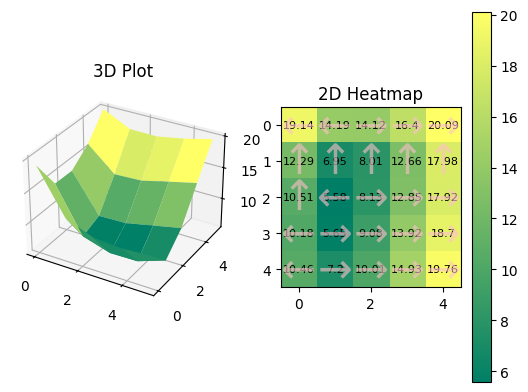

Iteration 10: 100%|██████████| 50/50 [00:02<00:00, 20.56it/s, episode=550, return=-29.000] 


epsilon: 0.945


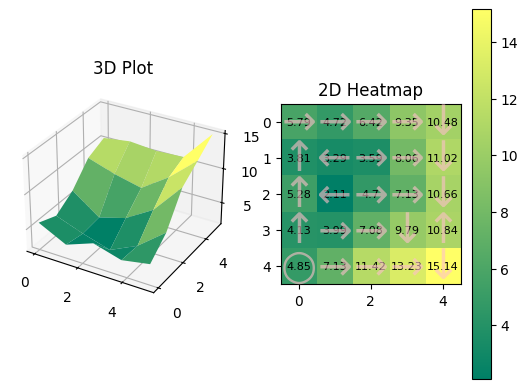

Iteration 20: 100%|██████████| 50/50 [00:01<00:00, 25.98it/s, episode=1050, return=-65.400]

epsilon: 0.8949999999999999


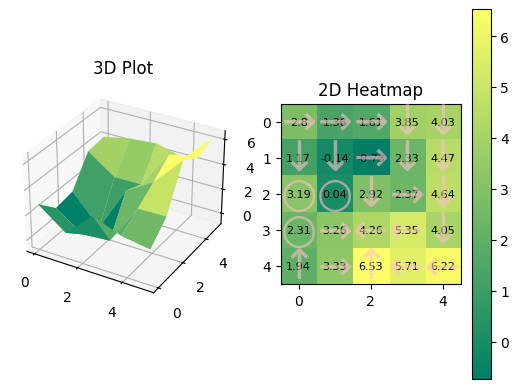

Iteration 30: 100%|██████████| 50/50 [00:01<00:00, 26.30it/s, episode=1550, return=-46.900]


epsilon: 0.8449999999999999


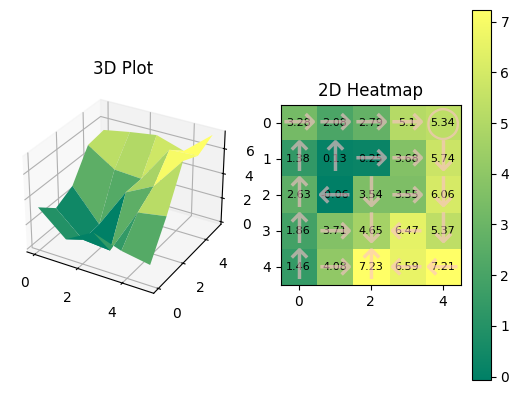

Iteration 40: 100%|██████████| 50/50 [00:01<00:00, 25.55it/s, episode=2050, return=-23.800]


epsilon: 0.7949999999999998


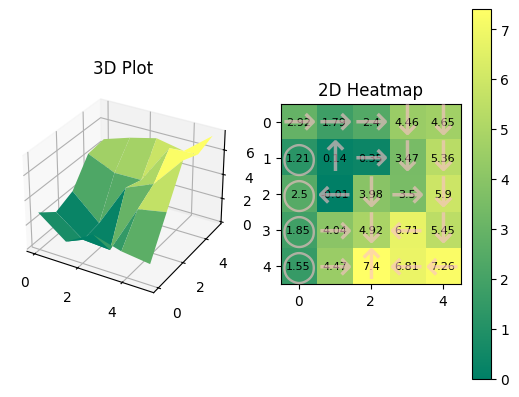

Iteration 50: 100%|██████████| 50/50 [00:01<00:00, 27.78it/s, episode=2550, return=-32.700]


epsilon: 0.7449999999999998


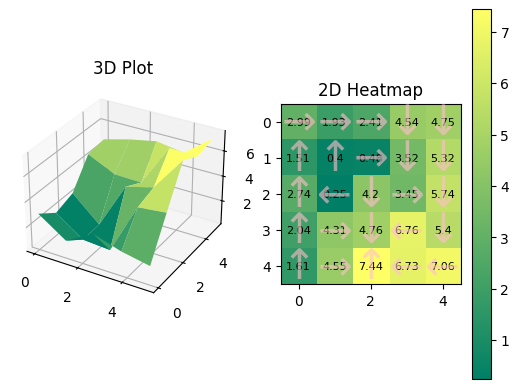

Iteration 60: 100%|██████████| 50/50 [00:01<00:00, 32.63it/s, episode=3050, return=-19.800]


epsilon: 0.6949999999999997


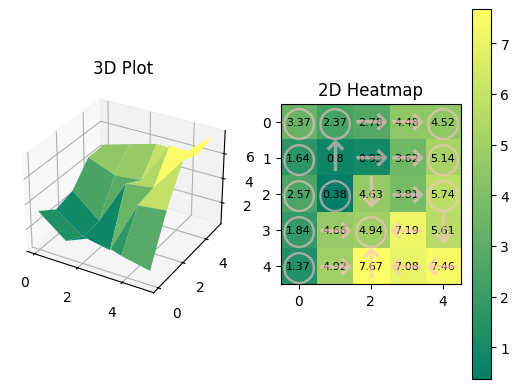

Iteration 70: 100%|██████████| 50/50 [00:01<00:00, 36.09it/s, episode=3550, return=-16.200]


epsilon: 0.6449999999999997


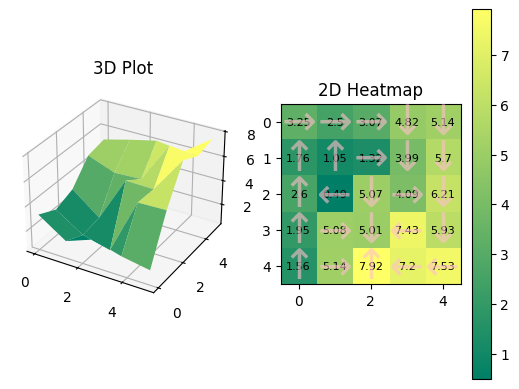

Iteration 80: 100%|██████████| 50/50 [00:01<00:00, 41.53it/s, episode=4050, return=-20.200]


epsilon: 0.5949999999999996


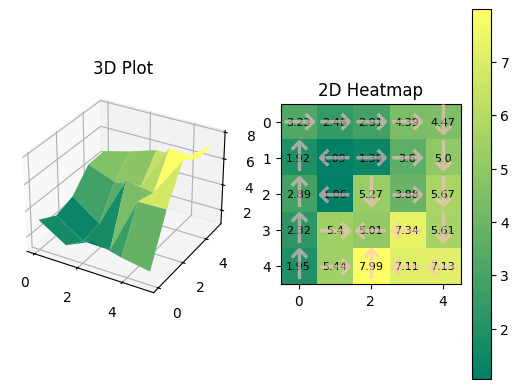

Iteration 90: 100%|██████████| 50/50 [00:01<00:00, 39.16it/s, episode=4550, return=-9.000] 


epsilon: 0.5449999999999996


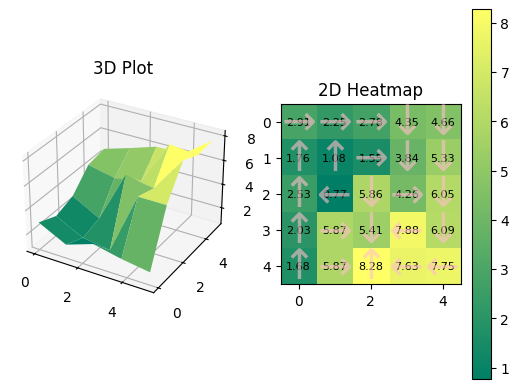

Iteration 99: 100%|██████████| 50/50 [00:01<00:00, 40.22it/s, episode=5000, return=-4.000] 


In [6]:
lr = 0.0015
num_episodes = 500
hidden_dim = 128
gamma = 0.9
epsilon = 1
target_update = 10
buffer_size = 10000
minimal_size = 16
batch_size = 8
device = torch.device("cpu") 
# if torch.cuda.is_available() else torch.device("cpu")


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)


state_dim = 2
action_dim = 5
agent = DQN(
    state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device
)

return_list = []
for i in range(100):
    with tqdm(total=int(num_episodes / 10), desc="Iteration %d" % i) as pbar:
        # print(replay_buffer.size())
        if epsilon > 0.05:
            epsilon -= 0.005
        agent.epsilon = epsilon
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                # print(1)
                action = agent.take_action((state // 5, state % 5))
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(
                    (state // 5, state % 5),
                    action,
                    reward,
                    (next_state // 5, next_state % 5),
                    done,
                )
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        "states": b_s,
                        "actions": b_a,
                        "next_states": b_ns,
                        "rewards": b_r,
                        "dones": b_d,
                    }
                    agent.update(transition_dict)
            # print(6)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix(
                    {
                        "episode": "%d" % (num_episodes / 10 * i + i_episode + 1),
                        "return": "%.3f" % np.mean(return_list[-10:]),
                    }
                )
            pbar.update(1)

    if i % 10 == 0:
        print("epsilon:", epsilon)
        s = np.array([[i, j] for i in range(5) for j in range(5)])
        states = torch.tensor(s, dtype=torch.float32).to(device)

        action_values = agent.target_q_net(states).cpu().view(-1, 5).detach().numpy()

        greedy_policy = np.argmax(action_values, axis=1)

        one_hot_policy = np.eye(5)[greedy_policy]  # 把传入的一维列表，转成二维one-hot型

        # p1是目标方向的概率，p0是另外四个方向的概率
        p1 = 1 - epsilon * (4 / 5)
        p0 = epsilon / 5
        d = {1: p1, 0: p0}
        policy_epsilon = np.vectorize(d.get)(one_hot_policy)  # 生成一个epsilon的policy

        state_values = np.sum(policy_epsilon * action_values, axis=1)

        draw(state_values.reshape(5, 5), greedy_policy)
